In [0]:
pip install imbalanced-learn

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
from pyspark.ml.linalg import Vectors 


In [0]:
# Load data
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/mrajakum@gmu.edu/fraud_dataset.csv")
df1 = df1.dropna()  # Drop rows with missing values

In [0]:
print("Data Schema:")
df1.printSchema()

Data Schema:
root
 |-- step: string (nullable = true)
 |-- customer: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- zipcodeOri: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- zipMerchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- fraud: string (nullable = true)
 |-- transaction_frequency: string (nullable = true)
 |-- avg_transaction_amount: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- merchant_interaction: string (nullable = true)
 |-- amount_change_pct: string (nullable = true)
 |-- zip_distance: string (nullable = true)
 |-- category_count: string (nullable = true)



In [0]:
# numeric_columns = ['age', 'amount', 'transaction_frequency', 'avg_transaction_amount', 
#                    'time_of_day', 'amount_change_pct', 'category_count']

# df1.select(numeric_columns).describe().show()

## Feature Engineering 

In [0]:
# Imputation using mean for column with infinite values

print("Before cleaning:")
df1.select('amount_change_pct').describe().show()

from pyspark.sql import functions as F

# Replace inf and -inf with None (null)
df1 = df1.withColumn(
    'amount_change_pct',
    F.when((F.col('amount_change_pct') == float('inf')) | (F.col('amount_change_pct') == float('-inf')), None)
    .otherwise(F.col('amount_change_pct'))
)

# Fill NaN (None) values with the column mean
mean_value = df1.agg(F.mean('amount_change_pct')).collect()[0][0]
df1 = df1.fillna({'amount_change_pct': mean_value})

# Check the updated column
print("After cleaning:")
df1.select('amount_change_pct').describe().show()


Before cleaning:
+-------+--------------------+
|summary|   amount_change_pct|
+-------+--------------------+
|  count|              593465|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|-0.00015181417944...|
|    max|                 inf|
+-------+--------------------+

After cleaning:
+-------+--------------------+
|summary|   amount_change_pct|
+-------+--------------------+
|  count|              593465|
|   mean|   4.519510203413529|
| stddev|   136.9528402088432|
|    min|-0.00015181417944...|
|    max|              999.75|
+-------+--------------------+



In [0]:
df1.count()

Out[5]: 593465

In [0]:
# Cast numeric columns to DoubleType

numeric_columns = ['age', 'amount', 'transaction_frequency', 'avg_transaction_amount', 
                   'time_of_day', 'amount_change_pct', 'category_count']
for col_name in numeric_columns:
    df1 = df1.withColumn(col_name, col(col_name).cast("double"))

# Cast fraud column to IntegerType
df1 = df1.withColumn('fraud', col('fraud').cast("int"))

# Handle categorical columns with StringIndexer

categoricalCols = ["step", "gender", "merchant", "category", "merchant_interaction"]
stringIndexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="skip").fit(df1) for col in categoricalCols]
for indexer in stringIndexers:
    df1 = indexer.transform(df1)



In [0]:
# --- Log Transformation --- 
from pyspark.sql.functions import log, when

# Apply log transformation using Spark's log function
log_columns = ['amount', 'avg_transaction_amount', 'amount_change_pct']

for col_name in log_columns:
    df1 = df1.withColumn(f"{col_name}_log", when(col(col_name) > 0, log(col(col_name))).otherwise(0))


In [0]:
# --- Feature Assembly ---
assemblerInputs = [col + "_Index" for col in categoricalCols] + [f"{col}_log" if col in log_columns else col for col in numeric_columns]
print("Assembler Inputs: ", assemblerInputs)

Assembler Inputs:  ['step_Index', 'gender_Index', 'merchant_Index', 'category_Index', 'merchant_interaction_Index', 'age', 'amount_log', 'transaction_frequency', 'avg_transaction_amount_log', 'time_of_day', 'amount_change_pct_log', 'category_count']


In [0]:
# Check for missing or invalid data before assembling the vector
for col_name in assemblerInputs:
    df1 = df1.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))

# VectorAssembler to create a feature vector
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df1 = vecAssembler.transform(df1)

In [0]:
df1.head()


Out[10]: Row(step='0', customer='C1093826151', age=4.0, gender="'M'", zipcodeOri='28007', merchant="'M348934600'", zipMerchant='28007', category="'es_transportation'", amount=4.55, fraud=0, transaction_frequency=167.0, avg_transaction_amount=28.24071856287425, time_of_day=0.0, merchant_interaction='154', amount_change_pct=0.0, zip_distance='0', category_count=154.0, step_Index=178.0, gender_Index=1.0, merchant_Index=1.0, category_Index=0.0, merchant_interaction_Index=154.0, amount_log=1.515127232962859, avg_transaction_amount_log=3.3407648571623123, amount_change_pct_log=0.0, features=DenseVector([178.0, 1.0, 1.0, 0.0, 154.0, 4.0, 1.5151, 167.0, 3.3408, 0.0, 0.0, 154.0]))

## Data Split

In [0]:
# --- Data Splitting ---
trainDF, testDF = df1.randomSplit([0.8, 0.2], seed=42)

# Rename 'fraud' to 'label' to match the model's expectation
testDF = testDF.withColumnRenamed("fraud", "label")

In [0]:
df1.head()

Out[12]: Row(step='0', customer='C1093826151', age=4.0, gender="'M'", zipcodeOri='28007', merchant="'M348934600'", zipMerchant='28007', category="'es_transportation'", amount=4.55, fraud=0, transaction_frequency=167.0, avg_transaction_amount=28.24071856287425, time_of_day=0.0, merchant_interaction='154', amount_change_pct=0.0, zip_distance='0', category_count=154.0, step_Index=178.0, gender_Index=1.0, merchant_Index=1.0, category_Index=0.0, merchant_interaction_Index=154.0, amount_log=1.515127232962859, avg_transaction_amount_log=3.3407648571623123, amount_change_pct_log=0.0, features=DenseVector([178.0, 1.0, 1.0, 0.0, 154.0, 4.0, 1.5151, 167.0, 3.3408, 0.0, 0.0, 154.0]))

## Handling class imbalance

Row(fraud=1, count=7193)


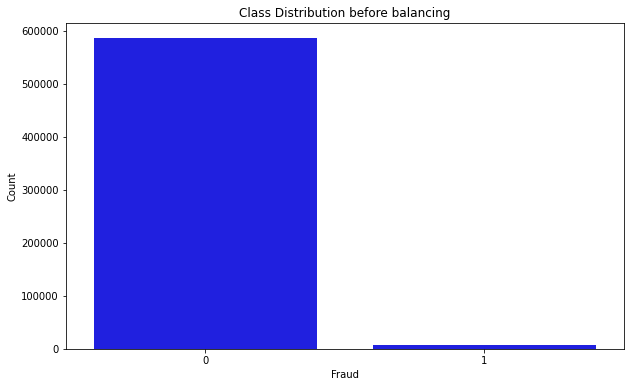

In [0]:
# Calculate the counts of each fraud class
fraud_counts = df1.groupBy("fraud").count()
print(fraud_counts.head())

# Convert to Pandas for plotting
fraud_counts_pandas = fraud_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='fraud', y='count', data=fraud_counts_pandas, color='blue')
plt.title('Class Distribution before balancing')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

In [0]:
# Convert Spark DataFrame to Pandas for SMOTE
trainDF_pandas = trainDF.select("features", "fraud").toPandas()
X = pd.DataFrame(trainDF_pandas["features"].tolist(), columns=[f"feature_{i}" for i in range(len(trainDF_pandas["features"][0]))])
y = trainDF_pandas["fraud"]

# Handle missing/infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Apply SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reassemble resampled data into Spark-compatible format
resampled_pandas = pd.concat([X_resampled, pd.Series(y_resampled, name="label")], axis=1)
resampled_pandas["features"] = resampled_pandas.iloc[:, :-1].apply(lambda row: Vectors.dense(row), axis=1)
balanced_data = spark.createDataFrame(resampled_pandas[["features", "label"]])


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Could not convert DenseVector([178.0, 1.0, 1.0, 0.0, 109.0, 4.0, 3.5591, 109.0, 4.5035, 0.0, 0.0, 65.0]) with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-opti

In [0]:
balanced_data.tail(5)

Out[15]: [Row(features=DenseVector([110.6805, 0.0, 12.623, 6.5287, 86.131, 3.0, 5.6269, 205.0, 5.162, 14.7172, 1.0826, 13.8115]), label=1),
 Row(features=DenseVector([169.0, 0.0, 34.0, 14.0, 1.5226, 4.5226, 5.7848, 91.4774, 5.3663, 11.0, 0.0, 2.5226]), label=1),
 Row(features=DenseVector([69.9138, 1.0, 34.0517, 13.931, 0.0, 3.9655, 5.0677, 175.9138, 3.4629, 17.9483, 1.0182, 1.0]), label=1),
 Row(features=DenseVector([57.002, 0.0, 24.0, 13.0, 85.0, 3.0, 7.0264, 108.0, 5.8893, 14.0158, -0.4401, 9.0]), label=1),
 Row(features=DenseVector([96.773, 1.0, 13.7946, 7.454, 0.0, 5.6595, 5.4059, 116.1135, 4.2102, 10.8865, 1.9444, 1.8865]), label=1)]

Row(label=0, count=468954)


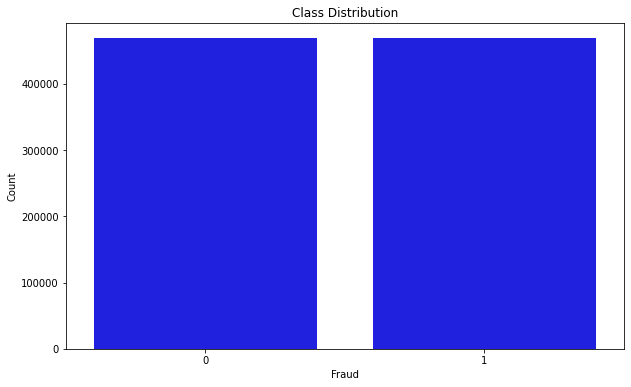

In [0]:
# Calculate the counts of each fraud class
fraud_counts = balanced_data.groupBy("label").count()
print(fraud_counts.head())

# Convert to Pandas for plotting
fraud_counts_pandas = fraud_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='count', data=fraud_counts_pandas, color='blue')
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

#### Classes are now balanced

## Feature Scaling

In [0]:
# --- Feature Scaling ---
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

## Model Training

In [0]:
# Logistic regression

# --- Model Building ---
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=10)

# Pipeline
pipeline_lr = Pipeline(stages=[scaler, lr])

# --- Model Training ---
lr_model = pipeline_lr.fit(balanced_data)

# --- Model Evaluation ---

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
predictions_lr = lr_model.transform(testDF)
roc_auc_lr = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression ROC-AUC: {roc_auc_lr}")

pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions_lr)
print(f"Precision-Recall AUC: {pr_auc}")

# Generate a confusion matrix

conf_matrix = predictions_lr.select("label", "prediction").groupBy("label", "prediction").count().show()



Logistic Regression ROC-AUC: 0.993623457459613
Precision-Recall AUC: 0.7286685480933472
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0|    55|
|    0|       0.0|112829|
|    1|       1.0|  1387|
|    0|       1.0|  4489|
+-----+----------+------+



In [0]:
# Random Forest Classifier
# --- Model Building ---
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=50)

# Pipeline
pipeline_rf = Pipeline(stages=[scaler, rf])

# --- Model Training ---
rf_model = pipeline_rf.fit(balanced_data)

# --- Model Evaluation ---

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
predictions_rf = rf_model.transform(testDF)
roc_auc_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest ROC-AUC: {roc_auc_rf}")

pr_auc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")
pr_auc = pr_auc_evaluator.evaluate(predictions_rf)
print(f"Precision-Recall AUC: {pr_auc}")

# Generate a confusion matrix

conf_matrix = predictions_rf.select("label", "prediction").groupBy("label", "prediction").count().show()

Random Forest ROC-AUC: 0.9947769601589515
Precision-Recall AUC: 0.7258510643677442
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0|    23|
|    0|       0.0|112849|
|    1|       1.0|  1419|
|    0|       1.0|  4469|
+-----+----------+------+



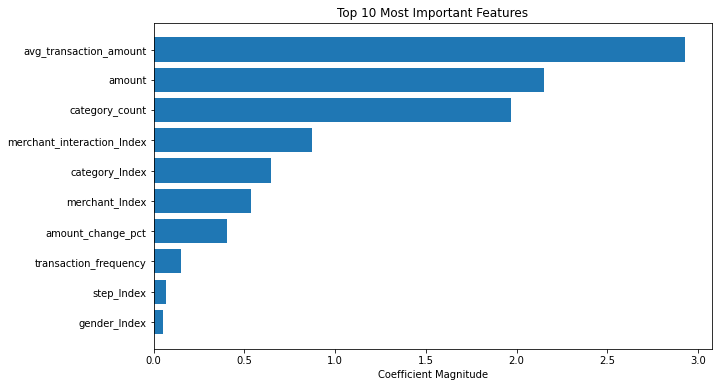

In [0]:
# List of feature columns used in VectorAssembler
feature_columns = [col + "_Index" for col in categoricalCols] + numeric_columns

# Extract coefficients from the Logistic Regression model
coefficients = lr_model.stages[-1].coefficients.toArray()  # Accessing the last stage (LogisticRegressionModel)

# Sort coefficients in descending order
importance = np.abs(coefficients)
indices = np.argsort(importance)[::-1]

# Plotting the top 10 most important features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importance[indices[:top_n]], align='center')
plt.yticks(range(top_n), np.array(feature_columns)[indices[:top_n]])  # Use feature_columns
plt.xlabel('Coefficient Magnitude')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis() 
plt.show()


#### Average Transaction amount emerges as the most important factor for detecting the fraud transactions

In [0]:
from pyspark.ml.classification import GBTClassifier

# --- Gradient Boosting Classifier ---
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="label", maxIter=50)

# Pipeline
pipeline_gbt = Pipeline(stages=[scaler, gbt])

# --- Model Training ---
gbt_model = pipeline_gbt.fit(balanced_data)

# --- Model Evaluation ---
predictions_gbt = gbt_model.transform(testDF)

roc_auc_gbt = evaluator.evaluate(predictions_gbt)
print(f"Gradient Boosting ROC-AUC: {roc_auc_gbt}")

pr_auc_gbt = pr_auc_evaluator.evaluate(predictions_gbt)
print(f"Gradient Boosting Precision-Recall AUC: {pr_auc_gbt}")

# Confusion Matrix
predictions_gbt.select("label", "prediction").groupBy("label", "prediction").count().show()



Gradient Boosting ROC-AUC: 0.9957352834463293
Gradient Boosting Precision-Recall AUC: 0.8705667062886998
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0|    77|
|    0|       0.0|115296|
|    1|       1.0|  1365|
|    0|       1.0|  2022|
+-----+----------+------+



In [0]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

# --- Feature Scaling ---
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Apply StandardScaler to Training and Test Data
scaler_model = scaler.fit(balanced_data)  # Train on balanced dataset
scaled_train_data = scaler_model.transform(balanced_data)  # Scale the training data
scaled_test_data = scaler_model.transform(testDF)  # Scale the test data

# Convert scaled training data to Pandas for XGBoost
train_data_pandas = scaled_train_data.select("scaled_features", "label").toPandas()
X_train = np.array(train_data_pandas["scaled_features"].tolist())
y_train = train_data_pandas["label"].values

# Convert scaled test data to Pandas for XGBoost
test_data_pandas = scaled_test_data.select("scaled_features", "label").toPandas()
X_test = np.array(test_data_pandas["scaled_features"].tolist())
y_test = test_data_pandas["label"].values

# --- Model Training ---
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Disable label encoding warnings
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42
)

xgb_model.fit(X_train, y_train)

# --- Model Evaluation ---
# Predict probabilities for test data
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc_xgb = auc(recall, precision)
print(f"XGBoost Precision-Recall AUC: {pr_auc_xgb}")

# Confusion Matrix
y_pred = xgb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: 

XGBoost ROC-AUC: 0.9987212937776976
XGBoost Precision-Recall AUC: 0.9369687925565893
Confusion Matrix:
[[117133    185]
 [   212   1230]]


In [0]:
# --- Model Evaluation ---
# Predict probabilities for test data
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc_xgb = auc(recall, precision)
print(f"XGBoost Precision-Recall AUC: {pr_auc_xgb}")

# Confusion Matrix
y_pred = xgb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

XGBoost ROC-AUC: 0.9987212937776976
XGBoost Precision-Recall AUC: 0.9369687925565893
Confusion Matrix:
[[117133    185]
 [   212   1230]]
